In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# FaceNet with memory vs. synthetic faces

This is an accompanying Jupyter Notebook for [this](https://medium.com/asap-report/facenet-with-memory-vs-synthetic-faces-8e87a009e139) Medium blog post.

In [2]:
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn-dark-palette')
mpl.style.use('seaborn-whitegrid')
%matplotlib inline

import tensorflow as tf
tf.set_random_seed(0)

from utils import (
    read_images,
    get_num_images_per_character,
    load_facenet,
    prepare_batch,
    plot_sim_mat,
    calc_embeddings,
    setup_memory,
    eval_facenet_without_memory,
    train_and_eval_facenet_with_memory,
    plot_results,
)

### Let's first familiarize ourselves with the characters

Notice the `do_prewhiten=False` which means we're not going to standardize the input.

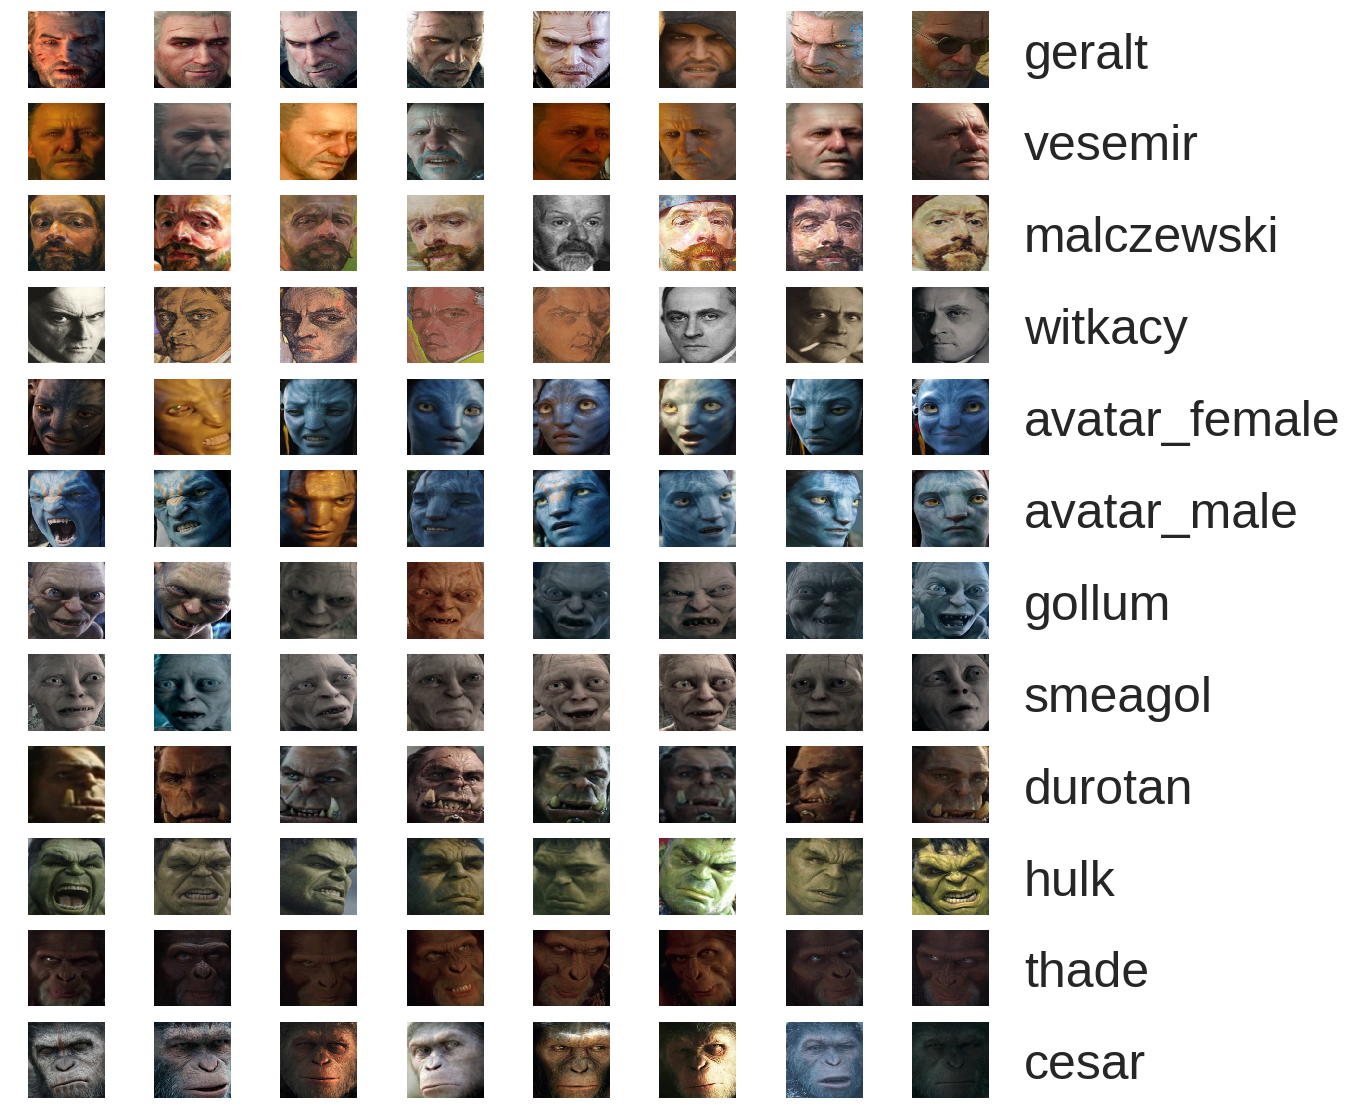

In [3]:
char_img_map = read_images(do_prewhiten=False)

num_classes = len(char_img_map)
num_images_per_character = get_num_images_per_character(char_img_map)

fig, axs = plt.subplots(num_classes, num_images_per_character+1, figsize=(20, 20))


for char_id, character in enumerate(char_img_map.keys()):
    axs[char_id, -1].text(0, 0.25, character, fontsize=50)
    axs[char_id, -1].set_axis_off()
    for ax, img in zip(axs[char_id], char_img_map[character]):
        ax.imshow(img.astype(np.uint8))
        ax.set_axis_off()

### Now, let's actually read in the images (with `do_prewhiten=True` as default)

In [4]:
char_img_map = read_images()
num_images_per_character = get_num_images_per_character(char_img_map)

### Create a `tf.Graph` called `my_graph` and a `tf.Session` called `my_sess`
We'll use them throught this notebook. We'll load FaceNet into them, and use them to carry out all calculations done in TensorFlow.

In [5]:
my_graph = tf.Graph()
my_sess = tf.Session(graph=my_graph)

### This is where we load FaceNet ...

In [6]:
images_pholder, phase_train_pholder, embeddings_var = load_facenet(my_graph, my_sess)

Model directory: 20170512-110547
Metagraph file: model-20170512-110547.meta
Checkpoint file: model-20170512-110547.ckpt-250000
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from 20170512-110547/model-20170512-110547.ckpt-250000


### and here we're calculating FaceNet's embeddings for the images

In [7]:
char_embedd_map = calc_embeddings(char_img_map, my_sess, images_pholder, phase_train_pholder, embeddings_var)

We can visualize the similarity between the embeddings as a matrix in which rows and columns are ordered according to character.

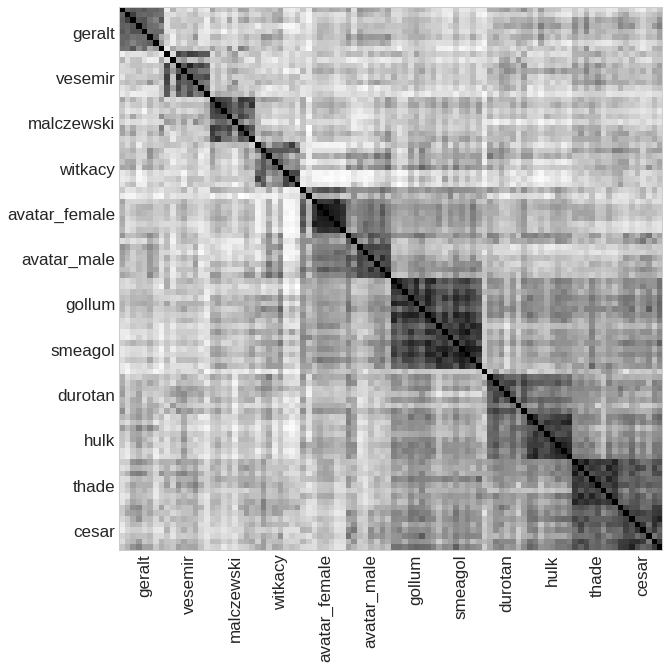

In [8]:
plot_sim_mat(char_embedd_map)

### OK, we're ready to produce results for the "FaceNet alone" model
I.e. the model that stores embeddings of all the embeddings it has seen thus far, and uses 1-nearest-neighbor approach to prediction.

In [9]:
results_facenet_alone = eval_facenet_without_memory(char_embedd_map)

### Before we do the same for "FaceNet + memory", we need to set up the `Memory`

In [10]:
mem_var_init_op, labels_pholder, closest_label_pred, train_op = setup_memory(my_graph, embeddings_var)

Instructions for updating:
dim is deprecated, use axis instead


### And now, we're ready to get results for the "FaceNet + memory" model

In [11]:
results_facenet_memory = train_and_eval_facenet_with_memory(char_img_map, my_sess, images_pholder, phase_train_pholder, labels_pholder, mem_var_init_op, train_op, closest_label_pred)

### Here we call the final function for plotting the accuracies and confusion matrices for both models

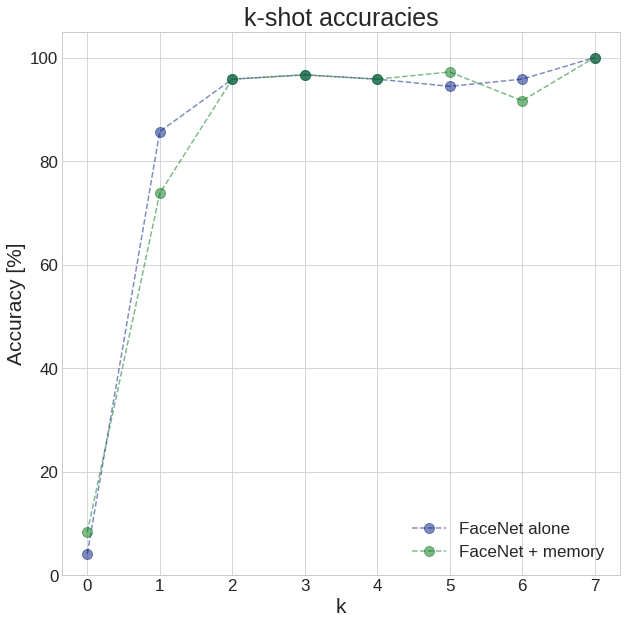

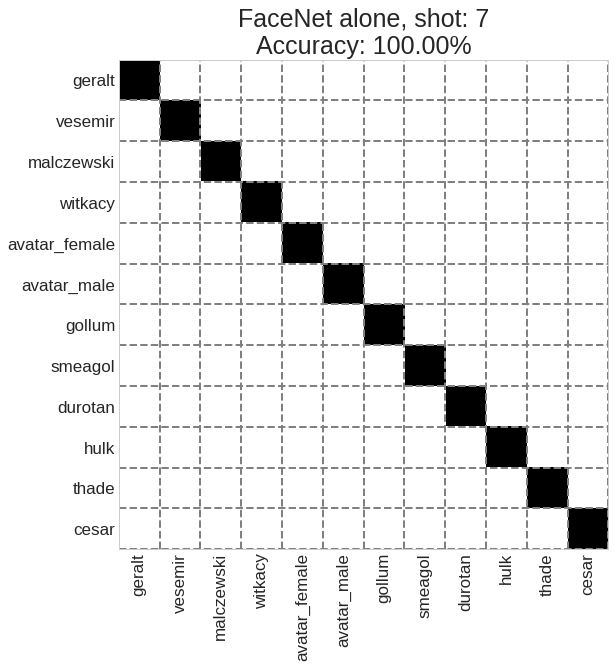

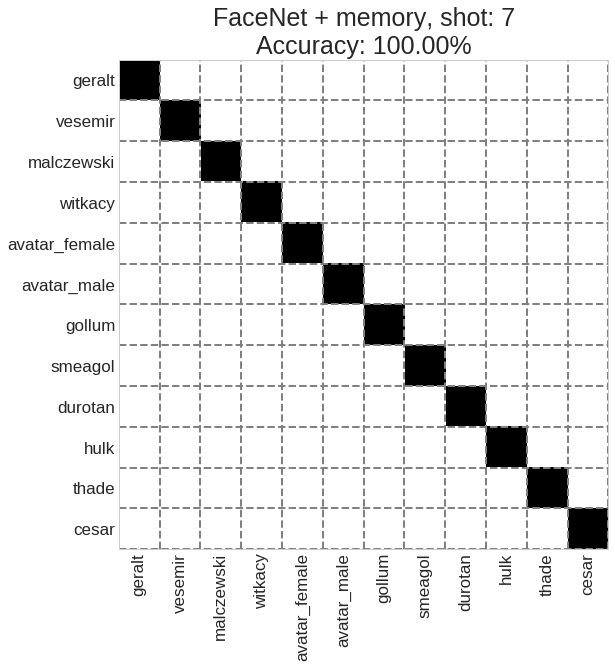

In [12]:
plot_results(results_facenet_alone, results_facenet_memory)